# Setting

In [1]:
datadir = './data'
outdir = './output'
#filename_300 = '211105_2_300K.csv' # 300K
#filename_77 = '211105_2_77K.csv' # 77K
#filename_300 = 'WaveData20211202_02_300K.csv' # Anritsu test
#filename_77 = 'WaveData20211202_02_77K_2.csv' # Anritsu test
filename_300 = 'WaveData20211202_01_MY_Y_300K.csv' # Anritsu test
filename_77 = 'WaveData20211202_01_MY_Y_77K.csv' # Anritsu test
csvType = 'Anritsu'; # Anritsu Spectrum analyzer: Waveform output
room_temp = 300. # room temperature in the measurement
rbw = XXX # Hz (need for gain calculation)

k_B = 1.380649e-23  # boltzmann const. [J/K]
freq_min = 0. # [GHz]
freq_max = 26.5 # [GHz]

#csvType = 'Anritsu'; # Anritsu Spectrum analyzer: Waveform output
#csvType = 'Keysight'; # Keysight Spectrum Analyzer: output
#csvType = 'OneColumn'; # dBm 
#csvType = 'TwoColumn'; # freq, dBm

# Import libraries

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt

# Define function to read csv datafile

In [3]:
# start_freq, stop_freq, npoints are only used in OneColumn type
def read_csv(filename, csvType='Anritsu', start_freq=None, stop_freq=None, npoints=None):
    
    freq = [] # frequency list [GHz]
    power = [] # power list  [mW]
    
    f = open(filename, 'r');
    if csvType=='TwoColumn':
        fin = list( csv.reader(f, delimiter=' ') )
    else:
        fin = list(csv.reader(f))
    #print(fin)  #リストの中身を出力
    isData = False
    
    if csvType=='Anritsu': # Anritsu : NOTE: only for RMS detection
        
        start_freq = 0
        stop_freq = 0
        npoints = 0
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            # Search for frequency range
            if first == 'Trace-A':
                start_freq = int(line[1])
                stop_freq  = int(line[2])
                continue
            # Search for npoints
            if first == 'RMS':
                npoints = int(line[1])
                continue
            # Search for data starting point (Anritsu: Wave Data)
            if first.startswith('Wave Data'):
                isData = True
                continue
            # Get data
            if isData:
                power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
                pass
            pass
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
            
    elif csvType=='Keysight' : # Keysight
        
        for line in fin:
            if len(line)==0 : continue
            # Search for data starting point (Keysight: DATA)
            #print(f'first = {first}')
            if first == 'DATA':
                isData = True
                continue
            isData = True # All lines are data
            # Get data
            if isData:
                freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
                power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
                pass
            pass
        
    elif csvType=='TwoColumn' : # Hz, dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
            power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
            pass
        
    elif csvType=='OneColumn' : # dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
            pass
        if (start_freq is None) or (stop_freq is None) or (npoints is None):
            print('Error! There is no arguments for frequency information (start_freq, stop_freq, npoints).')
            print('Error! Please specify them!')
            return None
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
        
        pass
    
    return np.array(freq), np.array(power)
                

# Define funcition to calculate frequency average

In [4]:
def freq_average(data, naverage=100):

    ndata = len(data)
    npoints = int(ndata/naverage)
    
    data_ave = []
    data_err = []
    
    for i in range(npoints):
        data_subset = data[i*naverage:(i+1)*naverage]
        average = np.mean(data_subset)
        average_err = np.std(data_subset)/np.sqrt(naverage) #  = 1/N * sqrt( sum((y-mean)^2))  ( std = sqrt( sum((y-mean)^2) / N) )
        data_ave.append(average)
        data_err.append(average_err)
        pass
    
    return np.array(data_ave), np.array(data_err)

# Read csv data

In [5]:
freq_300, power_300 = read_csv(f'{datadir}/{filename_300}', csvType)
freq_77, power_77 = read_csv(f'{datadir}/{filename_77}', csvType)
# Select data between freq_min and freq_max
power_300 = power_300[freq_300<=freq_max]
freq_300 = freq_300[freq_300<=freq_max]
power_300 = power_300[freq_300>=freq_min]
freq_300 = freq_300[freq_300>=freq_min]
power_77 = power_77[freq_77<=freq_max]
freq_77 = freq_77[freq_77<=freq_max]
power_77 = power_77[freq_77>=freq_min]
freq_77 = freq_77[freq_77>=freq_min]

In [6]:
print(freq_300)
print(power_300)
print(freq_77)
print(power_77)

[0.000000e+00 2.650000e-03 5.300000e-03 ... 2.649470e+01 2.649735e+01
 2.650000e+01]
[1.12745703e-03 3.74800361e-05 5.88301560e-08 ... 5.57699172e-07
 5.26138400e-07 5.13452178e-07]
[0.000000e+00 2.650000e-03 5.300000e-03 ... 2.649470e+01 2.649735e+01
 2.650000e+01]
[1.22800462e-03 4.03645393e-05 5.67413938e-08 ... 2.70333583e-07
 2.64301726e-07 2.60315483e-07]


###  Plot Power [mW]

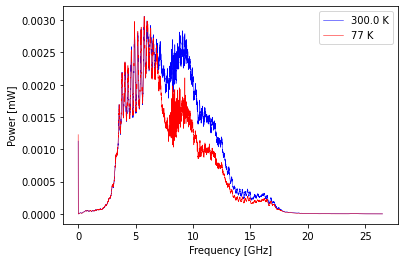

In [7]:
#plt.plot(freq_300, power_300, label=f'{room_temp} K', color='tab:blue', marker='o', markersize=0.5, linestyle='')
#plt.plot(freq_77, power_77, label=f'77 K', color='tab:red', marker='o', markersize=0.5, linestyle='')
plt.plot(freq_300, power_300, label=f'{room_temp} K', color='blue', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
plt.plot(freq_77, power_77, label=f'77 K', color='red', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定
plt.legend()

plt.savefig(f'{outdir}/power_mW.png')
plt.show()

###  Plot Power [dBm]

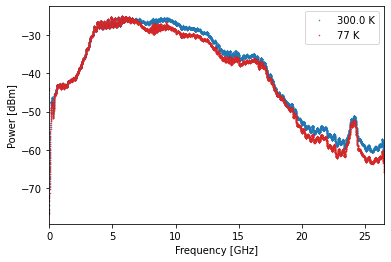

In [8]:
power_300_dBm = np.log10(power_300)*10.
power_77_dBm = np.log10(power_77)*10.

plt.plot(freq_300, power_300_dBm, label=f'{room_temp} K', color='tab:blue', marker='o', markersize=0.5, linestyle='')
plt.plot(freq_77, power_77_dBm, label=f'77 K', color='tab:red', marker='o', markersize=0.5, linestyle='')
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [dBm]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(-35,-20) #y軸範囲指定
plt.legend()

plt.savefig(f'{outdir}/power_dBm.png')
plt.show()

# Calculate gain & Trx (Y-factor claculation)

Y-factor calculation

もし、T の温度の暗室に測定系が存在したら、そこにある測定系が得られるパワーは(増幅はないものとして)

$$
P = k_B T B \times 10^{3} [mW]
$$
- $k_B$: ボルツマン定数 [J/K]
- $T$ : 暗室の温度 [K]
- $B$ : バンド幅 = RBW (resolution band width) [Hz]


$T_{77}$ K と $T_{300}$ K の測定をした場合、
$$
\begin{align}
P_{300} &= G k_B (T_{rx} + T_{300})B \times 10^{3} \tag{1}\label{300} \\
P_{77}  &= G k_B (T_{rx} + T_{77})B \times 10^{3} \tag{2}\label{77}
\end{align}
$$
注) $G \propto B$ で $G$ に $B$ を含まない! (DOUSE-K と同じ)
  
  
Y-factor は
$$ 
Y = \frac{P_{300}}{P_{77}} = \frac{T_{rx} + T_{300}}{T_{rx} + T_{77}} \\
\Leftrightarrow
T_{rx} = \frac{T_{300}-YT_{77}}{Y-1}  \tag{3}\label{Trx} \\
$$
また、(\ref{300}) - (\ref{77}) より
$$
\begin{align}
P_{300} - P_{77} &= G k_B (T_{300} - T_{77}) B \times 10^{3} \\
\Leftrightarrow
G &= \frac{1}{k_B\times B \times 10^{3}}\frac{P_{300}-P_{77}}{T_{300}-T_{77}}  \tag{4}\label{G}
\end{align}
$$ 

In [24]:
## Assume the same freq between 300K and 77K
if not np.all(freq_300 == freq_77):
    print('Error! The frequency should be the same between 300K and 77K data files.')
    pass

freq = freq_300
#Trx = power_300/(power_300-power_77) * (room_temp-77.) - room_temp
#gaink = (power_300-power_77)/(room_temp-77.) # Gain * k_B (boltzmann const.)
#gain = gaink / k_B
# Power [mW]
def Yfactor(power_300, power_77, T_300, T_77, err_power_300=None, err_power_77=None):
    Y = power_300/power_77
    Trx = (T_300-Y*T_77)/(Y-1.)
    G = (power_300-power_77)/(T_300-T_77)/(k_B*rbw*1e+3)
    err_Y = err_Trx = err_G = None
    if err_power_300 is not None and err_power_77 is not None:
        err_Y = np.sqrt( np.power(err_power_300/power_77, 2.) + np.power(Y/power_77*err_power_77,2.) )
        err_Trx = np.sqrt( np.power(Trx/(Y-1.)*err_Y, 2.) )
        err_G = np.sqrt( err_power_300**2. + err_power_77**2. )/(T_300-T_77)/(k_B*rbw*1e+3)
        pass
    return [Trx, G],[err_Trx, err_G]

[Trx, G],[tmp,tmp] = Yfactor(power_300, power_77, room_temp, 77.)
print(Trx)
print(G)
print(G*k_B*(Trx+room_temp))

# Suppress negative value for G
#G[G<=0.] = 1.e-100

[-2723.53661677 -3120.5693006   6057.81315092 ...   209.78290749
   225.09942604   229.32413211]
[-3.26575424e+13 -9.36877665e+11  6.78423438e+08 ...  9.33354482e+10
  8.50437358e+10  8.22180096e+10]
[1.09273881e-06 3.64840417e-08 5.95513878e-11 ... 6.56924062e-10
 6.16548373e-10 6.00858121e-10]


/Users/shadachi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/shadachi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


In [25]:
# Print Trx, G
print(f'Trx = {Trx}')
print(f'Gain = {G}')

Trx = [-2723.53661677 -3120.5693006   6057.81315092 ...   209.78290749
   225.09942604   229.32413211]
Gain = [-3.26575424e+13 -9.36877665e+11  6.78423438e+08 ...  9.33354482e+10
  8.50437358e+10  8.22180096e+10]


### Plot Trx

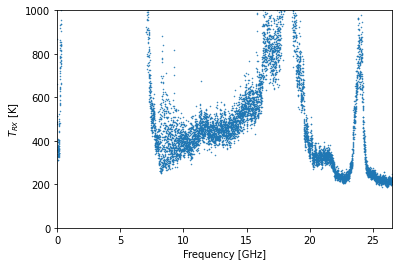

In [26]:
plt.plot(freq, Trx, marker='o', markersize=0.5, linestyle='')
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('$T_{RX}$ [K]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
plt.ylim(0,1000) #y軸範囲指定

plt.savefig(f'{outdir}/Trx.png')
plt.show()

### Plot Gain

/Users/shadachi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/shadachi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


ValueError: Axis limits cannot be NaN or Inf

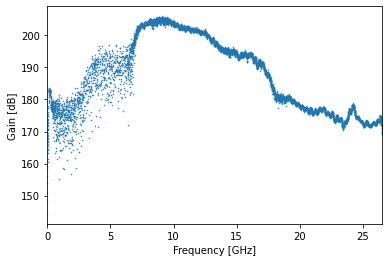

In [17]:
G_dB = np.log10(G)*10.;
plt.plot(freq, G_dB, marker='o', markersize=0.5, linestyle='')
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Gain [dB]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
plt.ylim(0.95*min(G_dB[G_dB>0.]),1.05*max(G_dB)) #y軸範囲指定

plt.savefig(f'{outdir}/Gain.png')
plt.show()

### Plot averaged power

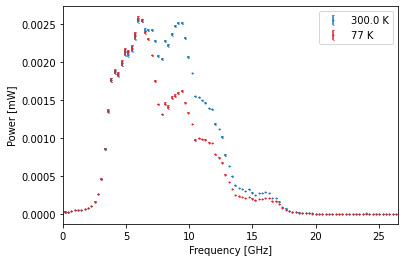

In [18]:
freq_ave, tmp = freq_average(freq, naverage=100)
power_300_ave, power_300_ave_err = freq_average(power_300, naverage=100)
power_77_ave, power_77_ave_err = freq_average(power_77, naverage=100)
plt.errorbar(freq_ave, power_300_ave, yerr=power_300_ave_err, label=f'{room_temp} K', capsize=0.5, fmt='o', markersize=1, ecolor='tab:blue', markeredgecolor = "tab:blue", color='tab:blue')
plt.errorbar(freq_ave, power_77_ave, yerr=power_77_ave_err, label=f'77 K',  capsize=0.5, fmt='o', markersize=1, ecolor='tab:red', markeredgecolor = "tab:red", color='tab:red')

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(0,0.006) #y軸範囲指定
plt.legend()

plt.savefig(f"{outdir}/power_average.png")
plt.show()

### Plot averaged Trx

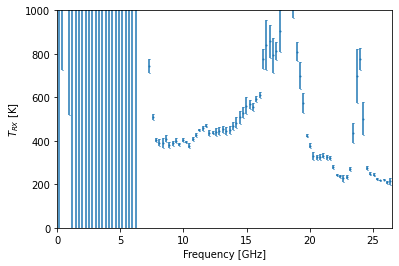

In [19]:
# Calculate from Trx
#freq_ave, tmp = freq_average(freq, naverage=100)
#Trx_ave, Trx_err = freq_average(Trx, naverage=100)

# Calculate from averaged powers
[Trx_ave, G_ave],[Trx_ave_err,G_ave_err] = Yfactor(power_300_ave, power_77_ave, room_temp, 77.,power_300_ave_err, power_77_ave_err)

plt.errorbar(freq_ave, Trx_ave, yerr=Trx_ave_err, capsize=0.5, fmt='o', markersize=1, ecolor='tab:blue', markeredgecolor = "tab:blue", color='tab:blue')

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('$T_{RX}$ [K]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
plt.ylim(0,1000) #y軸範囲指定


plt.savefig(f"{outdir}/Trx_average.png")
plt.show()

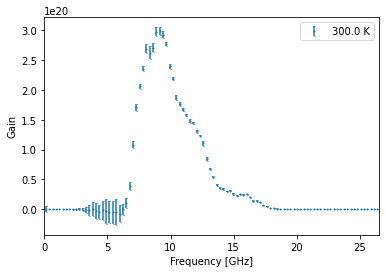

In [20]:
plt.errorbar(freq_ave, G_ave, yerr=G_ave_err, label=f'{room_temp} K', capsize=0.5, fmt='o', markersize=1, ecolor='tab:blue', markeredgecolor = "tab:blue", color='tab:blue')

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Gain') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(0,0.006) #y軸範囲指定
plt.legend()

plt.savefig(f"{outdir}/gain_average.png")
plt.show()

# Calculate & plot NEP [W/$\sqrt{Hz}$]

### Assumption for NEP calculation

In [21]:
dnu = 1.e+6 # RBW (resolution band width) [Hz]
Tload = 300 # Tload is supposed to be 300K.

### NEP calculation

$$
\begin{align}
 T_\mathrm{noise} &= T_\mathrm{RX} + T_\mathrm{load} \tag{5}\label{a} \\
 P_\mathrm{noise} &= k_B T_\mathrm{noise} \Delta \nu \tag{6}\label{b}
\end{align}
$$

<br>
<br>
$$
\begin{align}
 \mathrm{NEP} &= \sqrt{2 P_\mathrm{noise} k_B T_\mathrm{noise}} \\
\mathrm{(\ref{b}) より}  &  \\
     &= \sqrt{2\Delta\nu} k_B T_\mathrm{noise} \\
     &= \sqrt{2\Delta\nu} k_B (T_\mathrm{rx}+T_\mathrm{load}) \\
\end{align}
$$

測定するときの温度精度に換算すると

$$
\begin{align}
\Delta T_\mathrm{rms} 
    &= \frac{\mathrm{NET}}{\sqrt{t}}  \\
    &= \frac{\mathrm{NEP}}{k_B\Delta\nu \sqrt{t}} \\
    &= \frac{\sqrt{2} (T_\mathrm{rx}+T_\mathrm{load})}{\sqrt{\Delta\nu\,t}}
\end{align}
$$

注) $\sqrt{2}$ は $\mathrm{NEP}$ が 0.5 sec の時間積分でのノイズを表しているため。

In [22]:
NEP_ave = np.sqrt(2.*dnu) * k_B * (Trx_ave + Tload) 
NEP_ave_err = np.sqrt(2.*dnu) * k_B * Trx_ave_err

### Plot NEP

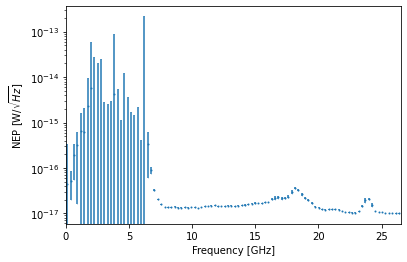

In [23]:
plt.errorbar(freq_ave, NEP_ave, yerr=NEP_ave_err, capsize=0.1, fmt='o', markersize=1, ecolor='tab:blue', markeredgecolor = "tab:blue", color='tab:blue')

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('NEP [W/$\sqrt{Hz}$]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(0.,1.2*np.max(nep_ave)) #y軸範囲指定
plt.yscale('log')

plt.savefig(f"{outdir}/NEP.png")
plt.show()